## Parsing the Lending Club data

In trying to reproduce the analysis in [Venka's blog post](https://juliacomputing.com/blog/2017/08/22/lendingclub-demo-blog.html) I was unable to get some of it working.  In this notebook I will show the steps that I was able to use to parse the data sets.

I suspect that some of my problem has to do with changes in the data sets.  In particular, there are now 137 fields in each of the CSV files and some further anonymizing appears to have been done.  The `id` and `member_id` fields are always empty strings and the `zip_code` field in now of the form `123xx` instead of `12345`.  This means it can't be parsed as an integer.

The files have been augmented with a few lines of information about totals at the bottom.

### Downloading and trimming the data

The files can be obtained in a `.csv.zip` format at the [Lending Club site](https://www.lendingclub.com/info/download-data.action).
After unzipping I ran a `sed` command like
```sh
~/LendingTree/data⟫ unzip ~/Downloads/LoanStats3a.csv.zip
Archive:  /home/bates/Downloads/LoanStats3a.csv.zip
  inflating: LoanStats3a.csv
~/LendingTree/data⟫ wc LoanStats3a.csv
   42544  2667455 41466518 LoanStats3a.csv
~/LendingTree/data⟫ sed -i -n -e '/^\"/p' LoanStats3a.csv
~/LendingTree/data⟫ wc LoanStats3a.csv
   42536  2667426 41466304 LoanStats3a.csv
```
to strip any lines that do not begin with the `"` character.

This leaves a total of 1,524,087 records in the CSV files.
```sh
~/LendingTree/data⟫ wc -l LoanStats*.csv
    133888 LoanStats_2016Q1.csv
     97855 LoanStats_2016Q2.csv
     99121 LoanStats_2016Q3.csv
    103547 LoanStats_2016Q4.csv
     96780 LoanStats_2017Q1.csv
    105452 LoanStats_2017Q2.csv
     42536 LoanStats3a.csv
    188182 LoanStats3b.csv
    235630 LoanStats3c.csv
    421096 LoanStats3d.csv
   1524087 total
```

Rename the files because they are out of sequence under the current names.
```sh
~/LendingClub/data⟫ mv LoanStats_2016Q1.csv LoanStats3e.csv
~/LendingClub/data⟫ mv LoanStats_2016Q2.csv LoanStats3f.csv
~/LendingClub/data⟫ mv LoanStats_2016Q3.csv LoanStats3g.csv
~/LendingClub/data⟫ mv LoanStats_2016Q4.csv LoanStats3h.csv
~/LendingClub/data⟫ mv LoanStats_2017Q1.csv LoanStats3i.csv
~/LendingClub/data⟫ mv LoanStats_2017Q2.csv LoanStats3j.csv
```

The CSV files contain headers.

In [1]:
fldnames = split(readline("data/LoanStats3a.csv"), ',');
length(fldnames)

137

In [2]:
using Glob
all(x -> split(readline(x), ",") == fldnames, glob("*.csv", "files"))

true

The strings in `fldnames` are quoted.
That is, they begin and end with a double quote, `"`.
It is easier to work with the names if these are stripped.

In [3]:
unquote(str) = match(r"^\"(.*)\"$", str).captures[1]
fldnms = Symbol.(unquote.(fldnames))

137-element Array{Symbol,1}:
 :id                                        
 :member_id                                 
 :loan_amnt                                 
 :funded_amnt                               
 :funded_amnt_inv                           
 :term                                      
 :int_rate                                  
 :installment                               
 :grade                                     
 :sub_grade                                 
 :emp_title                                 
 :emp_length                                
 :home_ownership                            
 ⋮                                          
 :hardship_status                           
 :deferral_term                             
 :hardship_amount                           
 :hardship_start_date                       
 :hardship_end_date                         
 :payment_plan_start_date                   
 :hardship_length                           
 :hardship_dpd            

### Using JuliaDB on a single file

[`Julia Computing`](https://juliacomputing.com) provides an very good CSV reader in the [`TextParse`](https://github.com/JuliaComputing/TextParse.jl) package, which is also available through the [`JuliaDB`](https://github.com/JuliaComputing/JuliaDB.jl) package.  Its ability to infer column types is better than anything I have seen.

It would make sense to start with the first of the files but, as is typical in such data collected over time, the first file is a bit of a learning experience and the fields are not consistent with later files.  It is easiest to start with a couple of files from the middle of the pack.

In [4]:
using JuliaDB
ls3d = load_table("data/LoanStats3d.csv", escapechar='"');
@time ls3f = load_table("data/LoanStats3f.csv", escapechar='"');

 42.918224 seconds (50.38 M allocations: 2.631 GiB, 1.54% gc time)


Individual columns or groups of columns can be accessed by name.

In [5]:
columns(ls3d, :loan_amnt)

421095-element Array{Int64,1}:
 14000
 35000
  4200
 12000
  8000
 11000
 15000
 18000
 21000
 16000
 15700
 23850
  7200
     ⋮
 12000
  7000
  4000
  7500
 10850
 12000
 11575
 24000
 10000
 12000
 13000
 20000

It is not easy to see but, at the top level, it is a 2-tuple, the first element being the data as a named tuple of columns and the second element being the names.  We can check the second element

Several of the columns in the 3d data set contain only missing data values.  They are of type `NullableArray{Union{}, 1}`.

To manipulate the columns more easily, create a [`DataTable`](https://github.com/JuliaData/DataTables.jl) representation.  

In [6]:
using DataTables
ls3dt = DataTable();
for nm in fldnms
    col = columns(ls3d, nm)
    if !isa(col, NullableArray{Union{}, 1})  # skip empty columns
        if nm ∉ (:desc, :title)      # skip "long answer" columns
            ls3dt[nm] = col
        end
    end
end

  likely near /home/bates/.julia/v0.6/IJulia/src/kernel.jl:31
  likely near /home/bates/.julia/v0.6/IJulia/src/kernel.jl:31


A good overview, if somewhat lengthy, is provided by `describe`.

In [7]:
describe(ls3dt)

loan_amnt
Summary Stats:
Mean:           15240.285862
Minimum:        1000.000000
1st Quartile:   8500.000000
Median:         14000.000000
3rd Quartile:   20000.000000
Maximum:        35000.000000
Length:         421095
Type:           Int64
Number Missing: 0
% Missing:      0.000000

funded_amnt
Summary Stats:
Mean:           15240.285862
Minimum:        1000.000000
1st Quartile:   8500.000000
Median:         14000.000000
3rd Quartile:   20000.000000
Maximum:        35000.000000
Length:         421095
Type:           Int64
Number Missing: 0
% Missing:      0.000000

funded_amnt_inv
Summary Stats:
Mean:           15234.156412
Minimum:        900.000000
1st Quartile:   8500.000000
Median:         14000.000000
3rd Quartile:   20000.000000
Maximum:        35000.000000
Length:         421095
Type:           Float64
Number Missing: 0
% Missing:      0.000000

term
Summary Stats:
Length:         421095
Type:           Nullable{String}
Number Unique:  2
Number Missing: 0
% Missing:      0.000

Summary Stats:
Mean:           3329.722381
Minimum:        0.000000
1st Quartile:   312.620000
Median:         529.340000
3rd Quartile:   3053.810000
Maximum:        36475.590000
Length:         421095
Type:           Float64
Number Missing: 0
% Missing:      0.000000

next_pymnt_d
Summary Stats:
Length:         421095
Type:           Nullable{String}
Number Unique:  5
Number Missing: 0
% Missing:      0.000000

last_credit_pull_d
Summary Stats:
Length:         421095
Type:           Nullable{String}
Number Unique:  33
Number Missing: 0
% Missing:      0.000000

collections_12_mths_ex_med
Summary Stats:
Mean:           0.020240
Minimum:        0.000000
1st Quartile:   0.000000
Median:         0.000000
3rd Quartile:   0.000000
Maximum:        14.000000
Length:         421095
Type:           Int64
Number Missing: 0
% Missing:      0.000000

mths_since_last_major_derog
Summary Stats:
Mean:           45.114741
Minimum:        0.000000
1st Quartile:   27.000000
Median:         45.000000
3rd

Summary Stats:
Mean:           13.765184
Minimum:        0.000000
1st Quartile:   0.000000
Median:         0.000000
3rd Quartile:   0.000000
Maximum:        159177.000000
Length:         421095
Type:           Int64
Number Missing: 0
% Missing:      0.000000

mo_sin_old_il_acct
Summary Stats:
Mean:           127.567419
Minimum:        0.000000
1st Quartile:   101.000000
Median:         130.000000
3rd Quartile:   153.000000
Maximum:        724.000000
Length:         408841
Type:           Int64
Number Missing: 12254
% Missing:      2.910032

mo_sin_old_rev_tl_op
Summary Stats:
Mean:           186.586697
Minimum:        3.000000
1st Quartile:   120.000000
Median:         170.000000
3rd Quartile:   237.000000
Maximum:        851.000000
Length:         421095
Type:           Int64
Number Missing: 0
% Missing:      0.000000

mo_sin_rcnt_rev_tl_op
Summary Stats:
Mean:           13.451247
Minimum:        0.000000
1st Quartile:   4.000000
Median:         8.000000
3rd Quartile:   16.000000
Maxi

Number Unique:  2
Number Missing: 0
% Missing:      0.000000

hardship_reason
Summary Stats:
Length:         421095
Type:           Nullable{String}
Number Unique:  9
Number Missing: 0
% Missing:      0.000000

hardship_status
Summary Stats:
Length:         421095
Type:           Nullable{String}
Number Unique:  4
Number Missing: 0
% Missing:      0.000000

deferral_term
Summary Stats:
Mean:           153.086712
Minimum:        0.000000
1st Quartile:   0.000000
Median:         3.000000
3rd Quartile:   3.000000
Maximum:        134465.000000
Length:         888
Type:           Int64
Number Missing: 420207
% Missing:      99.789121

hardship_amount
Summary Stats:
Mean:           68.619279
Minimum:        0.000000
1st Quartile:   0.000000
Median:         25.265000
3rd Quartile:   107.287500
Maximum:        569.750000
Length:         888
Type:           Float64
Number Missing: 420207
% Missing:      99.789121

hardship_start_date
Summary Stats:
Length:         421095
Type:           Nullabl

LoadError: [91mArgumentError: quantiles are undefined in presence of NaNs[39m

### A quick look at the loan status

For the purposes of modeling, the response of interest is `load_status`.

In [9]:
using FreqTables
freqtable(ls3dt[:loan_status])

7-element Named Array{Int64,1}
Dim1                 │ 
─────────────────────┼───────
"Charged Off"        │  45328
"Current"            │ 231234
"Default"            │    793
"Fully Paid"         │ 129071
"In Grace Period"    │   4963
"Late (16-30 days)"  │   1689
"Late (31-120 days)" │   8017

Often times it is easier to interpret the proportion and to sort the values in decreasing order so that the important categories come first.

In [10]:
round.(sort(100freqtable(ls3dt[:loan_status]) ./ size(ls3dt, 1),
       rev=true), 1)

7-element Named Array{Float64,1}
Dim1                 │ 
─────────────────────┼─────
"Current"            │ 54.9
"Fully Paid"         │ 30.7
"Charged Off"        │ 10.8
"Late (31-120 days)" │  1.9
"In Grace Period"    │  1.2
"Late (16-30 days)"  │  0.4
"Default"            │  0.2

Over 85% of the loans are fully paid or current.  The other loans are in some stage of delinquency.

Create a binary indicator of delinquency.

In [11]:
del(str) = (str ∈ ("Fully Paid", "Current")) ? "N" : "Y"
using PooledArrays
ls3dt[:delinquent] = PooledArray(convert(Array, del.(ls3dt[:loan_status])))

421095-element PooledArrays.PooledArray{String,UInt8,1,Array{UInt8,1}}:
 "N"
 "N"
 "N"
 "N"
 "N"
 "N"
 "N"
 "Y"
 "N"
 "N"
 "N"
 "N"
 "N"
 ⋮  
 "N"
 "N"
 "N"
 "N"
 "Y"
 "Y"
 "N"
 "N"
 "N"
 "Y"
 "Y"
 "N"

The `:grade` column is an evaluation of the risk of default prior to the loan being given.  Applications given a higher grade should have lower frequency of delinquency.

In [12]:
deltbl = freqtable(ls3dt[:grade], ls3dt[:delinquent])

7×2 Named Array{Int64,2}
Dim1 ╲ Dim2 │    "N"     "Y"
────────────┼───────────────
"A"         │  70229    3107
"B"         │ 106855   10751
"C"         │ 101921   18646
"D"         │  48603   14051
"E"         │  25182    9766
"F"         │   6246    3571
"G"         │   1269     898

As before, it is more informative to view this as a proportion, but in this case, the proportion for each grade.

In [13]:
round.(100deltbl ./ sum(deltbl, 2), 1)

7×2 Named Array{Float64,2}
Dim1 ╲ Dim2 │  "N"   "Y"
────────────┼───────────
"A"         │ 95.8   4.2
"B"         │ 90.9   9.1
"C"         │ 84.5  15.5
"D"         │ 77.6  22.4
"E"         │ 72.1  27.9
"F"         │ 63.6  36.4
"G"         │ 58.6  41.4

We see that `grade` is a good predictor of loan default.
Nearly 96% percent of the applications given an `A` grade are current or fully paid, compared to less than 60% of those given a `G` grade.

A good way to visualize this relationship is a [`Mosaic plot`](https://en.wikipedia.org/wiki/Mosaic_plot).
I know how to create this in `R`.

In [14]:
using RCall

INFO: Recompiling stale cache file /home/bates/.julia/lib/v0.6/RCall.ji for module RCall.
INFO: Using R installation at /usr/lib/R
  likely near In[14]:1
  likely near In[14]:1


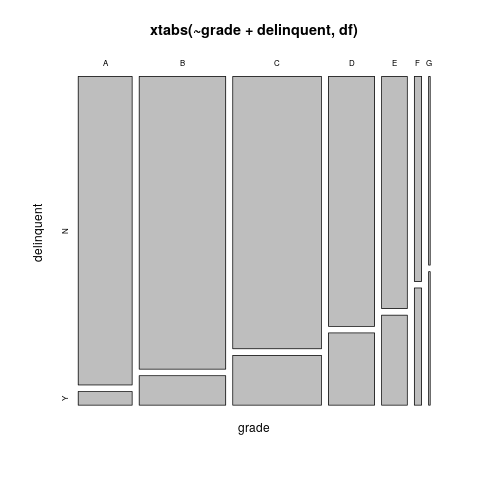

In [19]:
R"""
df <- data.frame(grade = ordered($(ls3dt[:grade])),
   delinquent = factor($(ls3dt[:delinquent])))
plot(xtabs(~ grade + delinquent, df))
""";

### Back to data cleaning

Those with experience in data science realize that reading the CSV files is just the first step in the "data cleaning" or "data wrangling" part of an analysis.

It is very difficult to determine an appropriate storage format from a CSV file alone.  As the old joke goes, you can't make the process foolproof because the fools are so inventive.  They do things like including units in a numeric field.

In [20]:
describe(ls3dt[:term])

Summary Stats:
Length:         421095
Type:           Nullable{String}
Number Unique:  2
Number Missing: 0
% Missing:      0.000000


In [21]:
unique(ls3dt[:term])

2-element Array{Nullable{String},1}:
 " 60 months"
 " 36 months"

In [22]:
ls3dt[:term] = parse.(Int, getindex.(get.(ls3dt[:term]), [1:4]))

421095-element Array{Int64,1}:
 60
 60
 36
 36
 36
 36
 36
 60
 60
 60
 60
 60
 36
  ⋮
 36
 36
 36
 36
 36
 36
 36
 36
 36
 60
 60
 36

They write dates in forms that require special parsing.

In [23]:
unique(ls3dt[:issue_d])

12-element Array{Nullable{String},1}:
 "Dec-2015"
 "Nov-2015"
 "Oct-2015"
 "Sep-2015"
 "Aug-2015"
 "Jul-2015"
 "Jun-2015"
 "May-2015"
 "Apr-2015"
 "Mar-2015"
 "Feb-2015"
 "Jan-2015"

In [24]:
ls3dt[:issue_d] = Date.(convert(Array, ls3dt[:issue_d]), "u-y")

421095-element Array{Date,1}:
 2015-12-01
 2015-12-01
 2015-12-01
 2015-12-01
 2015-12-01
 2015-12-01
 2015-12-01
 2015-12-01
 2015-12-01
 2015-12-01
 2015-12-01
 2015-12-01
 2015-12-01
 ⋮         
 2015-01-01
 2015-01-01
 2015-01-01
 2015-01-01
 2015-01-01
 2015-01-01
 2015-01-01
 2015-01-01
 2015-01-01
 2015-01-01
 2015-01-01
 2015-01-01

After a conversion like this it is always a good idea to check the extrema.

In [27]:
extrema(ls3dt[:issue_d])

(Nullable{Date}(2015-01-01), Nullable{Date}(2015-12-01))

(I haven't figured out why these dates end up being `Nullable{Date}` and how to avoid this.)

In [25]:
ls3dt[:last_pymnt_d] = Date.(convert(Array, ls3dt[:last_pymnt_d]), "u-y")

421095-element Array{Date,1}:
 2017-07-01
 2017-07-01
 2017-07-01
 2016-11-01
 2017-07-01
 2016-10-01
 2017-07-01
 2017-05-01
 2017-07-01
 2017-07-01
 2017-07-01
 2017-07-01
 2016-08-01
 ⋮         
 2016-04-01
 2017-07-01
 2015-06-01
 2017-07-01
 2015-08-01
 2016-02-01
 2016-09-01
 2017-07-01
 2017-07-01
 2016-01-01
 2016-05-01
 2017-05-01

In [26]:
extrema(ls3dt[:last_pymnt_d])

(Nullable{Date}(0001-01-01), Nullable{Date}(2017-07-01))

In [28]:
sum(x -> x < Date("2000-01-01"), ls3dt[:last_pymnt_d])

Nullable{Int64}(294)